In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install pickle5 --quiet
# !python -m pip install --quiet --upgrade pip
# !pip install mindscope_utilities --quiet --upgrade

In [198]:
import numpy as np
import pandas as pd
import os
import pickle5 as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [199]:
path="/content/drive/MyDrive/NMA_Project/PreprocessedFiles_Novel"
raw_data_path = "/content/drive/MyDrive/NMA_Project/dataset/tmp"
#put the folder in PreprocessedFiles_Novel in your drive or change path into the shared NMA Project folder/PreprocessedFiles_Novel/

In [129]:
def load_aligned_data(experiment_id):
    """Load aligned data from pickles + npy files.
    Experiment_id: experiment id as a string
    Path: path to the folder with data (absolute path is safest)
    behavior_types: running_speed, pupil_diameter, lick_rate. If passive, no lick rate!
    """
    behavior_types=['running_speed','pupil_diameter', 'lick_rate']
    data = None
    with open(os.path.join(path, f'ophys_aligned_neural_traces_{experiment_id}.p'), "rb") as fh:
      data = pickle.load(fh)

    neural_df = pd.DataFrame(data)
    neural_ts = np.load(os.path.join(path,f'ophys_aligned_neural_traces_timestamps_{experiment_id}.npy'))
    with open(os.path.join(path,f'ophys_aligned_behavior_traces_{experiment_id}.p'), "rb") as fh:
      data = pickle.load(fh)
    behavior_df = pd.DataFrame(data)
    behavior_ts_dict = {}
    for bt in behavior_types:
        try:
            behavior_ts_dict[bt] = np.load(os.path.join(path, f'ophys_aligned_behavior_{bt}_traces_timestamps_{experiment_id}.npy'))
        except FileNotFoundError as e:
            if bt == 'lick_rate': 
                print(f'Lick rate not found for experiment {experiment_id}, assuming passive, continuing...')
            else:
                raise(e)
    return neural_df, neural_ts, behavior_df, behavior_ts_dict
def get_average_neural_response_for_each_cell(aligned_neural_format, lim = 1e-5,drop = None):
  '''
      aligned_neural_format: the preprcessed neural data
      lim: limiting activity
      drop: list of stimulus_ids. drops stimuluses present in this list
      Returns:
      avg_responses: Dict with cell id as key corresponding to
        average response of cell over different trials at times 
        wrt stimulus
  '''

  if drop:
    print('Dropped: ',aligned_neural_format.shape)
    aligned_neural_format = aligned_neural_format[~aligned_neural_format['stimulus_presentations_id'].isin(drop)]
    print(aligned_neural_format.shape)
  gb_cell_neural = aligned_neural_format.groupby('cell_specimen_id')
  

  avg_responses = {}
  for name, group in gb_cell_neural:
    if group.mean_response.mean() > lim:
      avg_traces = np.stack(group['trace'].to_numpy())
      avg_traces = np.mean(avg_traces,axis = 0)
      avg_responses[name] = avg_traces
  return avg_responses

def get_average_behaviour_response_for_each_cell(aligned_behavior_format,drop = None):
  '''
      aligned_behavior_format: the preprcessed neural data
      lim: limiting activity
      drop: list of stimulus_ids. drops stimuluses present in this list
      Returns:
      avg_responses: Dict with cell id as key corresponding to
        average response of cell over different trials at times 
        wrt stimulus
  '''

  if drop:
    print('Dropped: ',aligned_behavior_format.shape)
    aligned_behavior_format = aligned_behavior_format[~aligned_behavior_format['stimulus_presentations_id_running'].isin(drop)]
    print(aligned_behavior_format.shape)
 
  avg_traces = np.stack(aligned_behavior_format['trace_running'].to_numpy())
  avg_traces = np.mean(avg_traces,axis = 0)
  return avg_traces
  


def plot_average_responses(avg_responses):
  '''
  avg_responses: Dict with cell id as key corresponding to
        average response of cell over different trials at times 
        wrt stimulus
  '''
  plt.figure(figsize=(10,10))
  # we can sort the cell ids here
  av_res = np.stack(list(avg_responses.values()))
  plt.imshow(av_res,cmap='gray')
  plt.show()
def event_plot_average_responses(avg_responses):
  '''
  avg_responses: Dict with cell id as key corresponding to
        average response of cell over different trials at times 
        wrt stimulus
  '''
  plt.figure(figsize=(10,10))
  # we can sort the cell ids here
  av_res = list(avg_responses.values())
  plt.eventplot(av_res)
  plt.show()

In [67]:
ids = [880375092,848697604,950833329, 948507789, 938003662, 1050406399] # experiment id
# mouse_id = [449441,445270]

    {'imaging_depth': 175, 'targeted_structure': 'VISp'},
    {'imaging_depth': 375, 'targeted_structure': 'VISp'},
    {'imaging_depth': 175, 'targeted_structure': 'VISp'},
    {'imaging_depth': 175, 'targeted_structure': 'VISp'},
    {'imaging_depth': 175, 'targeted_structure': 'VISp'},
    {'imaging_depth': 275, 'targeted_structure': 'VISp'}

In [179]:
sel_exp_id = 2

In [184]:
res = load_aligned_data(ids[sel_exp_id])

In [200]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=raw_data_path)
# exp_data = cache.get_behavior_ophys_experiment(880375092)

In [181]:
exp_table = cache.get_ophys_session_table()

In [ ]:
exp_id = 1050406399
exp = exp_table.iloc(exp_id)

In [8]:
# exp_data.stimulus_presentations.to_csv(raw_data_path+'/stimulus_presentations_880375092.csv')

In [185]:
exp_data =  pd.read_csv(raw_data_path+f'/stimulus_presentations_{ids[sel_exp_id]}.csv')
drop = exp_data.query('is_change == @False')['stimulus_presentations_id']
drop = drop.tolist()

In [186]:
aligned_neural_format = res[0]
aligned_neural_ts_format = res[1]
aligned_behavior_format = res[2]
aligned_behavior_ts_format = res[3]

In [187]:
aligned_behavior_ts_format.keys()

dict_keys(['running_speed', 'pupil_diameter', 'lick_rate'])

In [195]:
x_z = 0
x_b_z = 0
for i,a in enumerate(aligned_neural_ts_format):
  if i > 0 and a >= 0 and aligned_neural_ts_format[i-1] < 0:
      x_z = i
      print(x_z)
      break
for i,a in enumerate(aligned_behavior_ts_format['running_speed']):
  if i > 0 and a >= 0 and aligned_behavior_ts_format['running_speed'][i-1] < 0:
      x_b_z = i
      print(x_b_z)
      break

1578
180


In [189]:
len(aligned_neural_format['cell_specimen_id'].unique())


17

In [190]:
avg_responses = get_average_neural_response_for_each_cell(aligned_neural_format,drop=drop,lim=1e-20)

Dropped:  (81685, 6)
(3774, 6)


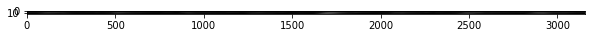

In [197]:
plot_average_responses(avg_responses)

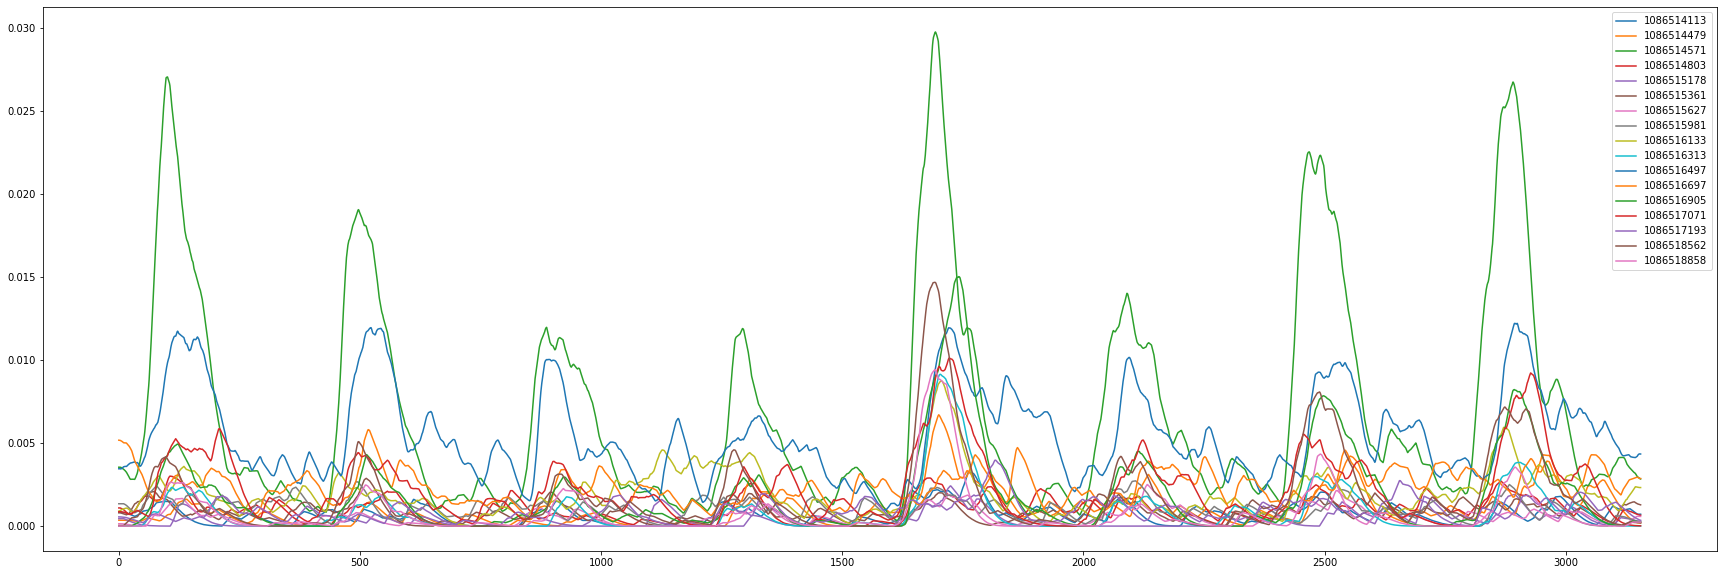

In [196]:
plt.figure(figsize=(30,10))
for k,v in avg_responses.items():
  plt.plot(v)
plt.legend(labels = list(avg_responses.keys()))
plt.show()


In [193]:
runn = get_average_behaviour_response_for_each_cell(aligned_behavior_format,drop=drop)

Dropped:  (4805, 15)
(222, 15)


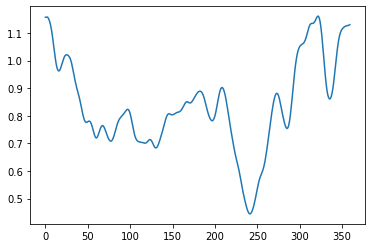

In [194]:
plt.plot(runn)

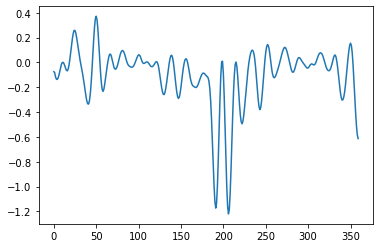

In [154]:
plt.plot(aligned_behavior_format['trace_running'][2340])

In [ ]:
# plt.figure(figsize=(15,10))

# for ind,x in enumerate(res):
 
#     aligned_neural_format = x[0]
#     aligned_neural_ts_format = x[1]
#     aligned_behavior_format = x[2]
#     aligned_behavior_ts_format = x[3]
#     x_z = 0
#     for i,a in enumerate(aligned_neural_ts_format):
#         if a == 0:
#             x_z = i
    
#     stim_id = 0
#     mean_res = 0.000
#     all_traces = aligned_neural_format.query('stimulus_presentations_id == @stim_id')
#     responsive_traces = all_traces.query('mean_response > @mean_res')
#     responsive_traces = np.stack(responsive_traces['trace'].to_numpy())
    
#     ax = plt.subplot(1,len(ids),ind+1)
#     ax.set_title(f"Responsive Neurons: {len(responsive_traces)} Total Neurons: {len(all_traces)}")
#     plt.imshow(responsive_traces,cmap='gray')


# plt.show()

In [201]:
exp_table = cache.get_ophys_experiment_table()

In [ ]:
int_tab= exp_table.query('imaging_depth == 175 and targeted_structure == \'VISp\' and passive == False and experience_level != \'Novel >1\'')

In [219]:
len(int_tab.index)

146

In [221]:
int_tab.to_csv('/content/drive/MyDrive/NMA_Project/dataset/interest_table.csv')